# Constraints
Generally, a vector-valued constraints function, $g$, defines a solution $x$ as feasible if and only if $g_i(x) \le 0$ for all $i$. In order to optimize a function with some constraints, we use the class `ConstrainedFitnessAL` which constructs an (unconstrained) augmented Lagrangian objective function from the objective and arbitrary non-linear constraints.

For some positive and changing parameters $\lambda_i, \mu_i$, the constructed function is

$$x\mapsto f(x) + \sum_i (\lambda_i g_i + \frac{\mu_i}{2}g_i^2)$$

where $g_i := \max\left(g_i(x), -\lambda_i/\mu_i\right)$, see at the end of the notebook for a picture. This is not expected to work well if the constraint is a step function at the feasibility boundary.

For simplicity, let's consider a single constraint that restricts the second variable to values $\le-1$. 


In [1]:
import cma

fun = cma.ff.elli  # we could use `functools.partial(cma.ff.elli, cond=1e4)` to change the condition number to 1e4
def constraints(x):
    return [x[1] - -1, x[1] - -0.9]  # constrain the second variable to <= -1, the second constraint is superfluous
cfun = cma.ConstrainedFitnessAL(fun, constraints)  # unconstrained function with adaptive Lagrange multipliers

x0 = 4 * [2]  # initial solution
sigma0 = 1    # initial standard deviation to sample new solutions

x, es = cma.fmin2(cfun, x0, sigma0, {'tolstagnation': 0}, callback=cfun.update)
x = es.result.xfavorite  # the original x-value may be meaningless
constraints(x)  # show constraint violation values

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=780871, Sat Mar 19 16:15:27 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.278912176704603e+05 1.0e+00 1.08e+00  1e+00  1e+00 0:00.0
    2     16 -4.895986721939695e+04 1.4e+00 1.41e+00  1e+00  2e+00 0:00.0
    3     24 -6.781532363715812e+04 1.5e+00 2.04e+00  2e+00  2e+00 0:00.0
  100    800 1.000000299153491e+02 8.6e+02 4.99e-03  1e-05  9e-03 0:00.2
  187   1496 1.000000000000001e+02 9.9e+02 2.47e-06  2e-10  2e-07 0:00.4
termination on tolfun=1e-11 (Sat Mar 19 16:15:28 2022)
final/bestever f-value = 1.000000e+02 -6.781532e+04
incumbent solution: [-1.7348312340817969e-07, -0.9999999992555643, 5.660483623687163e-10, -9.037810985289137e-11]
std deviation: [1.6708746891068538e-07, 1.0743261327807437e-09, 2.3242193320780015e-09, 1.9387992909444594e-10]


[7.444357352781594e-10, -0.09999999925556424]

The solution `es.result.xfavorite` is expected to be close to the feasible domain, but it may not be "stricly" feasible. To find a truly feasible solution, we can run a post-optimization like

In [2]:
c = es.countiter
x = cfun.find_feasible(es)
print("find_feasible took {} iterations".format(es.countiter - c))
constraints(x)  # is now <= 0

find_feasible took 1 iterations


[-2.4587887281768417e-11, -0.10000000002458787]

We can also plot the time evolution of feasibility and augmented Lagrangian parameters and, of course, the standard plot: 

In [3]:
# "%matplotlib widget" gives interactive inline plots (pip install --upgrade jupyterlab ipympl); CAVEAT: it does not open a new figure automatically
# fix failing variable completion: %config Completer.use_jedi = False

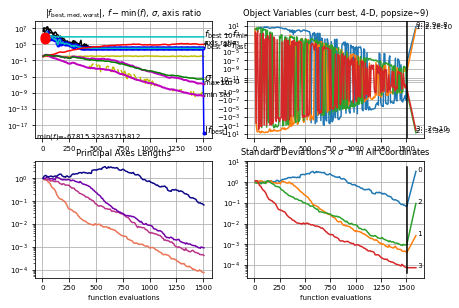

In [4]:
es.plot(xsemilog=True, x_opt=[0, -1] + (len(x0) - 2) * [0]);

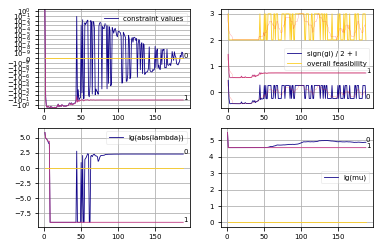

In [5]:
cfun.al.loggers.plot()

The `ConstrainedFitnessAL` class instance provides some more detailed information:

In [6]:
cfun.archives[0].archive  # non-dominated list of [f, aggregate(g)], feasible if aggregate(g) <= 0

[[99.99999995002723, 2.4986435143148356e-10],
 [99.99999995158464, 2.420772471367627e-10],
 [99.99999995465744, 2.2671531318962934e-10],
 [99.99999995920707, 2.0396684341505988e-10],
 [99.99999996347758, 1.8261370193783932e-10],
 [99.99999997000683, 1.4996692776492182e-10],
 [99.9999999743947, 1.2802670035227948e-10],
 [99.99999998500351, 7.498346388246091e-11],
 [99.99999999455002, 2.725319969698603e-11],
 [100.00000000491757, 0]]

In [7]:
cfun.archives[0].archive.infos[-1]

{'x': array([-6.24332393e-08, -1.00000000e+00,  8.96760019e-10, -6.74487309e-11]),
 'f': 100.00000000491757,
 'g': [-2.4587887281768417e-11, -0.10000000002458787],
 'f_al': 99.99999999999999,
 'g_al': [-4.917577762049309e-09, 0.0],
 'count': 1502}

Details about the best feasible solution can be found under its `info` attribute.


In [8]:
cfun.best_feas.info

{'x': array([-6.24332393e-08, -1.00000000e+00,  8.96760019e-10, -6.74487309e-11]),
 'f': 100.00000000491757,
 'g': [-2.4587887281768417e-11, -0.10000000002458787],
 'f_al': 99.99999999999999,
 'g_al': [-4.917577762049309e-09, 0.0],
 'count': 1502}

The module also provides `cma.fmin_con2` as a (less transparent) access to the above functionality.

In [8]:
cma.fmin_con2

<function cma.evolution_strategy.fmin_con2(objective_function, x0, sigma0, constraints=<function no_constraints at 0x16a0f7600>, find_feasible_first=False, find_feasible_final=False, kwargs_confit=None, **kwargs_fmin)>

# Ask-and-Tell Interface
We can use the underlying `CMAEvolutionStrategy` class, on which `cma.fmin2` is based, to get more control over the optimization loop.

In [9]:
# a more verbose way to run ``_, es = cma.fmin2(cfun, x0, sigma0)``

cfun = cma.ConstrainedFitnessAL(fun, constraints)  # unconstrained function with adaptive Lagrange multipliers
es = cma.CMAEvolutionStrategy(x0, sigma0)

while not es.stop():
    X = es.ask()  # sample len(X) candidate solutions
    es.tell(X, [cfun(x) for x in X])
    cfun.update(es)
    es.logger.add()  # for later plotting
    es.disp()
es.result_pretty()

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=802147, Sat Mar 19 16:15:31 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 6.519817910322512e+05 1.0e+00 1.29e+00  1e+00  1e+00 0:00.0
    2     16 1.267873851202785e+06 1.3e+00 1.26e+00  1e+00  1e+00 0:00.0
    3     24 9.186901486294302e+05 1.3e+00 1.22e+00  1e+00  1e+00 0:00.0
  100    800 1.000807736058264e+02 5.9e+02 8.32e-02  3e-04  1e-01 0:00.2
  200   1600 9.999999999999909e+01 9.0e+02 1.89e-05  1e-09  9e-07 0:00.4
  221   1768 9.999999999999997e+01 1.3e+03 2.27e-06  5e-11  6e-08 0:00.5
termination on tolfun=1e-11
final/bestever f-value = 1.000000e+02 -1.174649e+05
incumbent solution: [2.75267401177924e-08, -1.0000000002399936, 4.955257681328431e-10, 2.1104863602584384e-11]
std deviation: [6.00153129289706e-08, 2.348016820137999e-10, 3.702175557504842e-10, 4.5398174472085e-11]


CMAEvolutionStrategyResult(xbest=array([ 3.12166836, -2.32016655,  2.39983587,  0.10269098]), fbest=-117464.85106198642, evals_best=94, evaluations=1768, iterations=221, xfavorite=array([ 2.75267401e-08, -1.00000000e+00,  4.95525768e-10,  2.11048636e-11]), stds=array([6.00153129e-08, 2.34801682e-10, 3.70217556e-10, 4.53981745e-11]), stop={'tolfun': 1e-11})

If the function or constraints take additional arguments, they can be assigned ahead of time using [`functools.partial`](https://docs.python.org/3/library/functools.html), even to a mutable data type which makes it possible to change them dynamically.

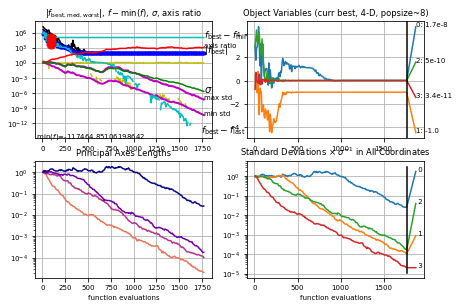

In [10]:
cma.plot();

## Understanding the Augmented Lagrangian
Shown is a quadratic objective function $f$ (blue), with the optimum in the infeasible domain, and a linear constraint $g$ (orange) leading to the augmented Lagrangian $x\mapsto f(x) + \lambda g + \frac{\mu}{2}g^2$ where $g := \max(g(x), -\lambda/\mu)$ shown in red. Because the coefficient $\lambda$ is slightly smaller than $-f'(x_0) / g'(x_0)$, where $x_0$ delineates feasible and infeasible domain ($g(x_0) = 0$), the optimum of the augmented Lagrangian is slightly in the infeasible domain. The penalty term $\lambda g + \frac{\mu}{2}g^2$ is the green curve which becomes flat to the left.

![constraints-augmented](constraints-augmented.png)